### Import libraries and dataset connection

In [1]:
import os, sys
import re
from typing import List
from collections.abc import Callable

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [79]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

plt.style.use(os.path.join(ASSETS_DIR, 'graphmel.mplstyle'))

sns.set(rc = {'figure.figsize':(15, 8)})

top_h_legend = dict(orientation='h', yanchor="bottom", y=1.02)

In [6]:
from ipywidgets import interact, interact_manual, FloatSlider

In [9]:
sys.path.append(os.path.abspath('..'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, load_dataset, \
                      fetch_data, preprocess, create_dataset, Preprocessor, standardise_column_names, \
                      retrieve_mapper, get_closest_blood_results, ASSETS_DIR

CONNECTION_DIR = '/Users/adhaene/Downloads/'

## Import data

In [41]:
files = os.listdir(os.path.join(ASSETS_DIR, 'results'))

files = sorted(list(zip(
    map(lambda fpath: os.path.getmtime(os.path.join(ASSETS_DIR, 'results', fpath)), files),
    files)), key=lambda t: t[0], reverse=True)

files[:6]

[(1638389890.825463, 'TEST_METRICS_2021-12-01 21:15:18.817083.csv'),
 (1638389890.499816, 'TRAIN_METRICS_2021-12-01 21:15:18.817083.csv'),
 (1638389680.6428714, 'TEST_METRICS_2021-12-01 21:02:12.968217.csv'),
 (1638389679.54034, 'TRAIN_METRICS_2021-12-01 21:02:12.968217.csv'),
 (1638388773.948979, 'TEST_METRICS_2021-12-01 20:55:59.367823.csv'),
 (1638388773.5862517, 'TRAIN_METRICS_2021-12-01 20:55:59.367823.csv')]

In [49]:
df1 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TRAIN_METRICS_2021-12-01 21:15:18.817083.csv'),
    index_col=0)
df1['suspicious'] = 0.75

df2 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TRAIN_METRICS_2021-12-01 21:02:12.968217.csv'),
    index_col=0)
df2['suspicious'] = 0.0

df3 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TRAIN_METRICS_2021-12-01 20:55:59.367823.csv'),
    index_col=0)
df3['suspicious'] = 0.5

df = pd.concat([df1, df2, df3]).reset_index()

df

,index,metric,value,step,run,suspicious
0,0,Loss - training,27.796828,0,0,0.75
1,1,Accuracy - training,0.583333,0,0,0.75
2,2,Loss - training,26.133049,1,0,0.75
3,3,Accuracy - training,0.694444,1,0,0.75
4,4,Loss - training,22.469590,2,0,0.75
...,...,...,...,...,...,...
2245,745,Accuracy - training,1.000000,122,2,0.50
2246,746,Loss - training,2.639689,123,2,0.50
2247,747,Accuracy - training,1.000000,123,2,0.50
2248,748,Loss - training,1.885824,124,2,0.50


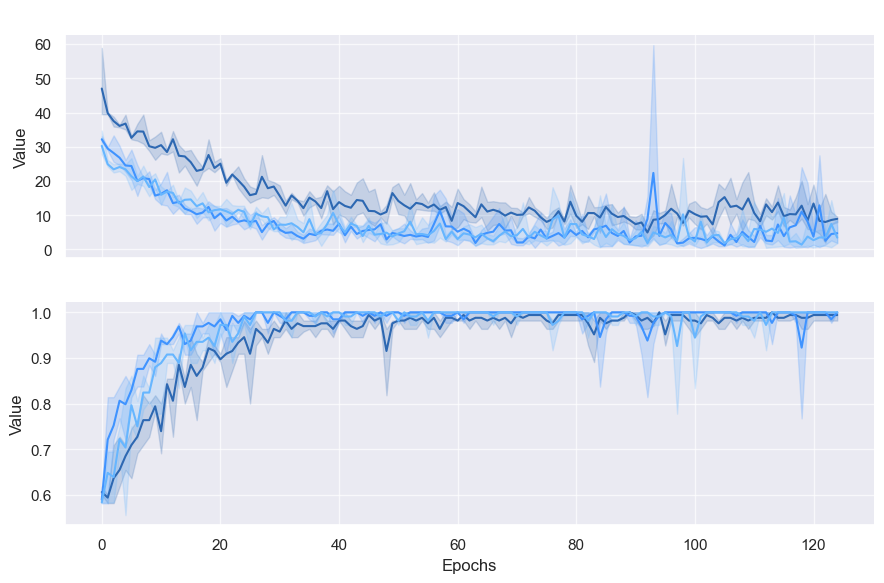

In [80]:
g = sns.FacetGrid(data=df, row='metric', sharey=False, height=3, aspect=3)

g.map_dataframe(sns.lineplot, x='step', y='value', hue='suspicious', palette=sns.color_palette(['#2d68b2', '#3f93ff', '#66b6ff']))
# g.add_legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3)

g.set_axis_labels("Epochs", "Value")
g.set_titles(row_template="{row_name}")

In [71]:
tf1 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 21:15:18.817083.csv'),
    index_col=0)
tf1['suspicious'] = 0.75

tf2 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 21:02:12.968217.csv'),
    index_col=0)
tf2['suspicious'] = 0.0

tf3 = pd.read_csv(
    os.path.join(ASSETS_DIR, 'results', 'TEST_METRICS_2021-12-01 20:55:59.367823.csv'),
    index_col=0)
tf3['suspicious'] = 0.5

tf = pd.concat([tf1, tf2, tf3]).reset_index(drop=True)

tf

,metric,value,suspicious
0,Accuracy - testing,0.411765,0.75
1,ROC AUC - testing,0.392857,0.75
2,Precision - testing,0.500000,0.75
3,Recall - testing,0.500000,0.75
4,Fscore - testing,0.500000,0.75
5,Accuracy - testing,0.458333,0.00
6,ROC AUC - testing,0.433333,0.00
7,Precision - testing,0.571429,0.00
8,Recall - testing,0.533333,0.00
9,Fscore - testing,0.551724,0.00


In [72]:
tf.pivot(index='suspicious', columns='metric')

value                                       \
metric     Accuracy - testing Fscore - testing Precision - testing   
suspicious                                                           
0.00                 0.458333         0.551724            0.571429   
0.50                 0.666667         0.750000            0.818182   
0.75                 0.411765         0.500000            0.500000   

                                               
metric     ROC AUC - testing Recall - testing  
suspicious                                     
0.00                0.433333         0.533333  
0.50                0.646154         0.692308  
0.75                0.392857         0.500000